### Imports

In [1]:
import numpy as np
from qutip import basis, enr_thermal_dm, destroy, mesolve, expect, wigner, plot_wigner, Options
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from function_definitions import potential, hamiltonian, initial_state, initial_energy, left_boundary, right_boundary, range_of_motion, time_partial_recompression, evolve, simulate, extract_wigner, marginal, mean_values, variances, energy, negativity_volume
from function_definitions import plot_mean_value_and_std_deviation, plot_potential, plot_wigner, plot_trace, plot_energy_error, plot_negativity_volume, plot_probability_last_two_fock_states
from function_definitions import number_of_fock_states, set_numerical_par

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.11 from "/Users/leo/opt/miniconda3/envs/qutip-env/bin/python"
  * The NumPy version is: "1.23.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Users/leo/opt/miniconda3/envs/qutip-env/lib/python3.11/site-packages/numpy/core/_multiarray_umath.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/libcblas.3.dylib
  Referenced from: <0CB3976A-DD5B-39DE-BAC5-4D0294F9A6F4> /Users/leo/opt/miniconda3/envs/qutip-env/lib/python3.11/site-packages/numpy/core/_multiarray_umath.cpython-311-darwin.so
  Reason: tried: '/Users/leo/opt/miniconda3/envs/qutip-env/lib/python3.11/site-packages/numpy/core/../../../../libcblas.3.dylib' (no such file), '/Users/leo/opt/miniconda3/envs/qutip-env/lib/python3.11/site-packages/numpy/core/../../../../libcblas.3.dylib' (no such file), '/Users/leo/opt/miniconda3/envs/qutip-env/bin/../lib/libcblas.3.dylib' (no such file), '/Users/leo/opt/miniconda3/envs/qutip-env/bin/../lib/libcblas.3.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libcblas.3.dylib' (no such file), '/Users/leo/opt/miniconda3/envs/qutip-env/lib/python3.11/site-packages/numpy/core/../../../../libcblas.3.dylib' (no such file), '/Users/leo/opt/miniconda3/envs/qutip-env/lib/python3.11/site-packages/numpy/core/../../../../libcblas.3.dylib' (no such file), '/Users/leo/opt/miniconda3/envs/qutip-env/bin/../lib/libcblas.3.dylib' (no such file), '/Users/leo/opt/miniconda3/envs/qutip-env/bin/../lib/libcblas.3.dylib' (no such file), '/usr/local/lib/libcblas.3.dylib' (no such file), '/usr/lib/libcblas.3.dylib' (no such file, not in dyld cache)


# Simulation

### Parameters

1. Set the parameters of the physical system

In [3]:
physical_parameters = {
    "n_bar" : 0,
    "x_s" : 0,
    "alpha" : 1e-3,
    "beta" : 0.5,
    "final_time" : 10
}

2. The function <code>set_numerical_par</code> sets automatically the numerical parameters of the simulation in a way that fits the physical problem of interest. The inputs to provide to <code>set_numerical_par</code> are:
* The number of points per unit along x and p (for the visualization of the Wigner function in the phase space);
* The number of points per unit in time (instants of time, during evolution, at which the state is stored inside the output <code>rho_list</code>);
* The dictionary <code>tolerance</code>, which allows to manually increase the range in x and p, as well as the number of Fock states included in the simulation.

**Note: The main parameter that determines the accuracy of the simulation is the size of the Fock basis used to represent the state at each time (i.e. the dimension of the Hilbert space).**

In [20]:
n_x_points_per_unit = 10
n_p_points_per_unit = 10
n_time_points_per_unit = 10
tolerance = {
    "delta_x" : 5,
    "delta_p" : 5,
    "n_fock" : 20
}

numerical_parameters = set_numerical_par(n_x_pu = n_x_points_per_unit, n_p_pu = n_p_points_per_unit, n_t_pu = n_time_points_per_unit, phys_par = physical_parameters, tolerance=tolerance)

Numerical parameters

x-range: ( -6.7286243127415455  --  6.7286243127415455 ) x_0
Number of points along x:  134
p-range: ( -6.2259690045021525  --  6.2259690045021525 ) p_0
Number of points along p:  124
Dimension of the Hilbert space:  25
Number of points in time:  34


The following cell demonstrates the role of the above mentioned input parameters on the representation of the Wigner function. The plot shows the Wigner function of the largest Fock state included in the finite-dimensional Hilbert space.
Note how:
* For increasing <code>n_x_points_per_unit</code> and <code>n_p_points_per_unit</code>, the grid in the phase space becomes denser and the Wigner function neater;
* For increasing <code>tolerance["delta_x"]</code> and <code>tolerance["delta_p"]</code>, the ranges in x and p grow and the Wigner function is zoomed out;
* For increasing <code>tolerance["n_fock"]</code>, the plotted Fock state changes: its Wigner function becomes larger and its fringes become denser. Similarly to the expansion in Fourier components, the higher the number of Fock states is considered in the simulation, the better will be the representation of generic Wigner functions.

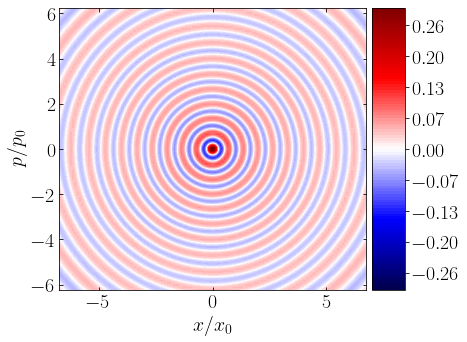

In [21]:
largest_fock_state = basis(numerical_parameters["dimension_Hilbert_space"], numerical_parameters["dimension_Hilbert_space"]-1)
plot_wigner(largest_fock_state, numerical_parameters, show_marg_x=False, show_marg_p=False)

3. Set up the overall parameters dictionary

In [22]:
parameters = {
    "physical": physical_parameters,
    "numerical" : numerical_parameters
}

4. (Optional) Make an approximate estimation of the time for partial recompression and overwrite the final time

In [23]:
final_time = time_partial_recompression(parameters)
parameters["physical"]["final_time"] = final_time
parameters["numerical"]["time_steps"] = int(final_time*10)

### Potential

5. Plot the potential energy

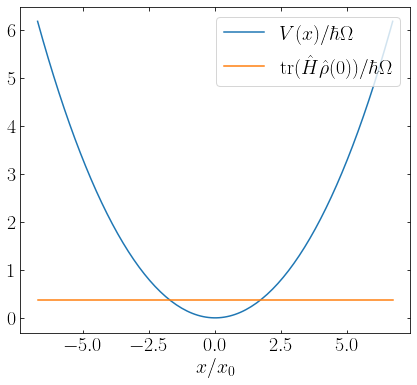

In [24]:
plot_potential(parameters)
# plt.gcf().savefig("path", facecolor='white', dpi=300)

### Evolution

6. Evolve the state of the system

**Note**: The time of execution of this task grows with the number of Fock states included in the simulation.

In [25]:
rho_list = simulate(parameters)

### Results

7. Compute mean values and variances in x and p

In [26]:
rho_f = rho_list[-1]

mean_x, mean_p = mean_values(rho_f, numerical_parameters)
var_x, var_p = variances(rho_f, numerical_parameters)

print("<x>/x_0 = %.2f," % mean_x, "<p>/p_0 = %.2f" % mean_p)
print("(<x^2> - <x>^2)/x_0^2 = %.2f," % var_x, "(<p^2> - <p>^2)/p_0^2 = %.2f" % var_p)

<x>/x_0 = 0.00, <p>/p_0 = 0.00
(<x^2> - <x>^2)/x_0^2 = 1.37, (<p^2> - <p>^2)/p_0^2 = 0.81


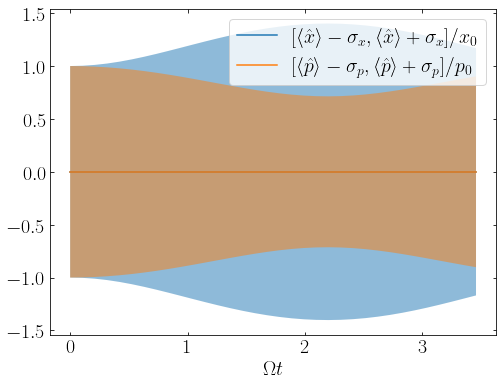

In [27]:
plot_mean_value_and_std_deviation(rho_list, parameters)

8. Plot the Wigner function at a given time step

**Note**: The time of execution of this task grows with the number of grid points in the phase space and the number of Fock states included in the simulation.

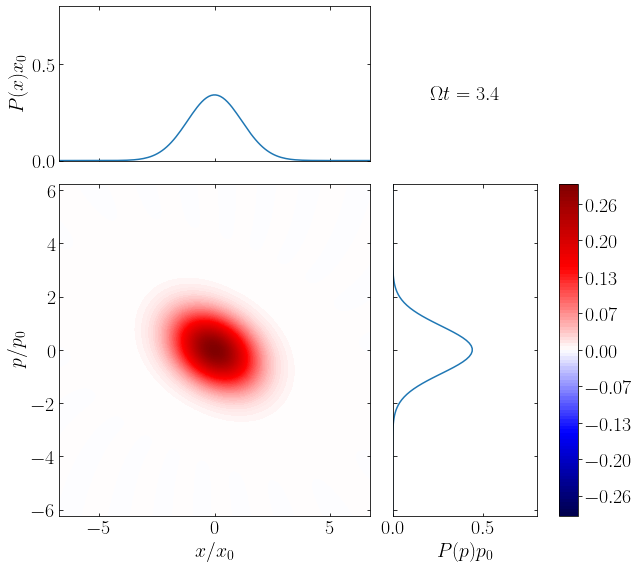

In [28]:
time_step = parameters["numerical"]["time_steps"]-1
plot_wigner(rho_list[time_step], parameters["numerical"], time=(time_step/parameters["numerical"]["time_steps"])*parameters["physical"]["final_time"])
# plt.gcf().savefig("path", facecolor='white', dpi=300)

In [29]:
def negativity_volume(rho, num_par):

    wigner = extract_wigner(rho, num_par)
    dx = np.mean(np.diff(num_par["x_coordinates"]))
    dp = np.mean(np.diff(num_par["p_coordinates"]))

    negativity = (1/2)*np.sum(np.abs(wigner)-wigner)*dx*dp
    
    return negativity

In [30]:
def plot_negativity_volume(rho_list, par):
    
    times = np.linspace(0, par["physical"]["final_time"], par["numerical"]["time_steps"])
    negativity_list = []

    for r in rho_list:
        negativity_list.append(negativity_volume(r, par["numerical"]))
    
    fontsize = 20

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_xlabel(r'$\Omega t$', fontsize=fontsize)
    ax.set_ylabel(r'$\mathcal{N}$', fontsize=fontsize)
    ax.tick_params(direction="in", top=True, right=True, labelsize=fontsize)
    ax.plot(times, negativity_list)

In [31]:
print("Negativity volume at t_f: ", negativity_volume(rho_list[-1], parameters["numerical"]))

Negativity volume at t_f:  1.2192380903415207e-06


9. Compute the negativity volume of the evolved states

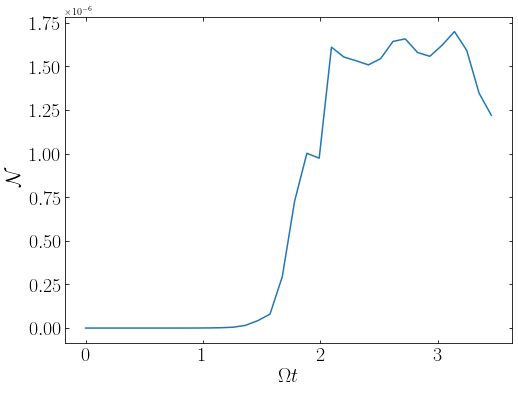

In [32]:
plot_negativity_volume(rho_list, parameters)

### Checks

Unity of the trace

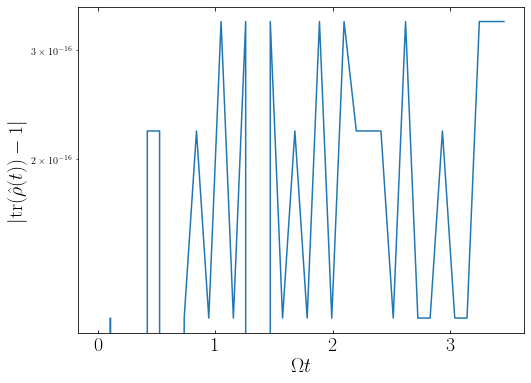

In [33]:
plot_trace(rho_list, parameters)

Conservation of energy

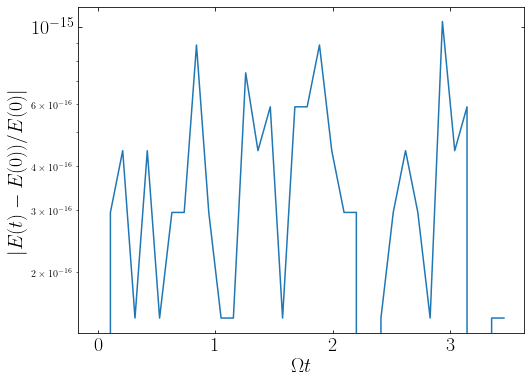

In [34]:
plot_energy_error(rho_list, parameters)

Probability to find the particle in the last two Fock states

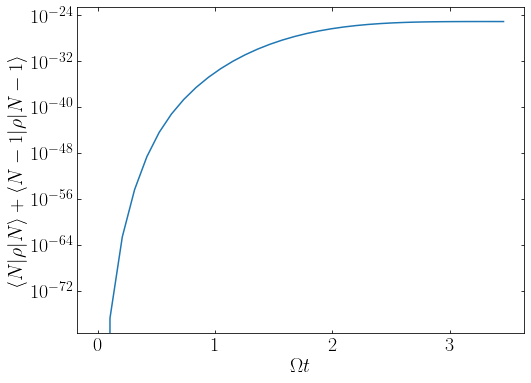

In [35]:
plot_probability_last_two_fock_states(rho_list, parameters)